# Architecture of a classification neural network

## Hyperparameter
* Input layer shape
* Hidden layers
* neurons per hidden layer
* Output layer shape
* Hidden layer activation
* Output activation
* Loss function
* Optimizer

## 1. Make classification data

In [62]:
from sklearn.datasets import make_circles

n_samples = 10000

X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

In [63]:
X.shape

(10000, 2)

In [64]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.046469,0.824778,1
1,1.005063,-0.433352,0
2,-0.583484,0.794528,0
3,0.984783,-0.325179,0
4,0.829930,-0.547223,0
5,-0.133929,0.776249,1
6,0.779197,0.645811,0
7,0.722955,0.173831,1
8,-0.121807,0.796951,1
9,0.849529,0.505678,0


In [65]:
# Check different labels
circles.label.value_counts()

label
1    5000
0    5000
Name: count, dtype: int64

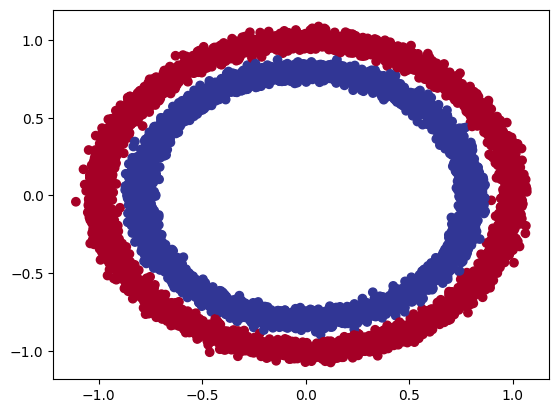

In [66]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

### 1.1 Input and output shapes

### 1.2 Turn data into tensors and create train and test split

In [67]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.0465,  0.8248],
         [ 1.0051, -0.4334],
         [-0.5835,  0.7945],
         [ 0.9848, -0.3252],
         [ 0.8299, -0.5472]]),
 tensor([1., 0., 0., 0., 0.]))

In [68]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(8000, 2000, 8000, 2000)

## 2. Building a model

In [69]:
import torch 
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [70]:
class CircleModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.model = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            # nn.Linear(self.hidden_size*2, self.hidden_size),
            # nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size), 
            # nn.Sigmoid()
        )
    def forward(self, x):
        output = self.model(x)
        return output

In [71]:
model = CircleModel(2,100,1).to(device)
model

CircleModel(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [72]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [73]:
untrained_preds = model(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 2000, Shape: torch.Size([2000, 1])
Length of test samples: 2000, Shape: torch.Size([2000])

First 10 predictions:
tensor([[-0.0767],
        [-0.1580],
        [-0.0564],
        [ 0.0151],
        [-0.0510],
        [-0.0510],
        [-0.0198],
        [-0.0247],
        [ 0.0069],
        [ 0.0191]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 1., 0., 1., 0., 1., 1., 1., 1., 1.])


### 2.1 Setup loss function and optimizer

In [74]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1)

In [12]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## 3. Train model
Pytorch training loop steps:
1. Forward pass - The model goes through all of the training data once, performing its forward() function calculations (model(X_train))
2. Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train)).
3. Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).
4. Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).
5. Step the optimizer (gradient descent) - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [76]:
y_logits = model(X_train.to(device))[:5]
y_logits = torch.sigmoid(y_logits)

In [77]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_logits)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([ True,  True, False,  True,  True])


tensor([0., 0., 1., 0., 1.], grad_fn=<SqueezeBackward0>)

### 3.2 Building a training and testing loop

In [78]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model(X_train).squeeze()
    y_pred = torch.sigmoid(y_logits)
    y_pred = torch.round(y_pred)
  
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69298, Accuracy: 50.22% | Test loss: 0.69269, Test acc: 51.50%
Epoch: 10 | Loss: 0.69110, Accuracy: 52.73% | Test loss: 0.69104, Test acc: 53.10%


Epoch: 20 | Loss: 0.68952, Accuracy: 53.73% | Test loss: 0.68955, Test acc: 53.80%
Epoch: 30 | Loss: 0.68798, Accuracy: 54.85% | Test loss: 0.68808, Test acc: 54.60%
Epoch: 40 | Loss: 0.68648, Accuracy: 56.84% | Test loss: 0.68661, Test acc: 55.85%
Epoch: 50 | Loss: 0.68504, Accuracy: 59.03% | Test loss: 0.68522, Test acc: 58.30%
Epoch: 60 | Loss: 0.68361, Accuracy: 61.44% | Test loss: 0.68381, Test acc: 60.55%
Epoch: 70 | Loss: 0.68212, Accuracy: 64.11% | Test loss: 0.68235, Test acc: 63.10%
Epoch: 80 | Loss: 0.68056, Accuracy: 66.70% | Test loss: 0.68081, Test acc: 65.90%
Epoch: 90 | Loss: 0.67894, Accuracy: 68.94% | Test loss: 0.67921, Test acc: 68.10%
Epoch: 100 | Loss: 0.67723, Accuracy: 70.67% | Test loss: 0.67752, Test acc: 69.95%
Epoch: 110 | Loss: 0.67541, Accuracy: 72.21% | Test loss: 0.67571, Test acc: 71.50%
Epoch: 120 | Loss: 0.67342, Accuracy: 73.70% | Test loss: 0.67373, Test acc: 72.25%
Epoch: 130 | Loss: 0.67131, Accuracy: 75.04% | Test loss: 0.67163, Test acc: 73.60%


## 4. Putting things together by building a multi-class Pytorch model

### 4.1 Creating multi-class classification data
To do so, we can leverage Scikit-Learn's make_blobs() method.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


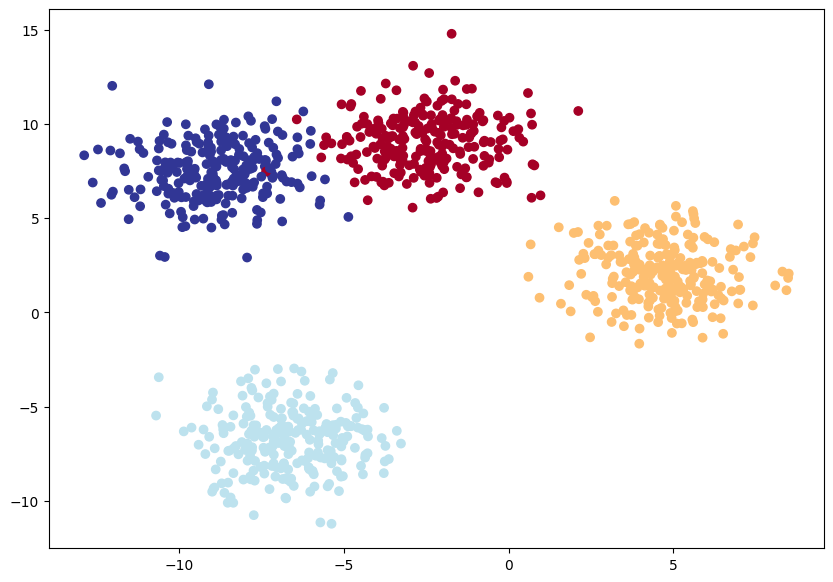

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [3]:
y_blob_train.shape

torch.Size([800])

## 8.2 Building a multi-class classification model in Pytorch

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
print(X_blob_train.shape)

torch.Size([800, 2])


In [5]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, hidden_units, output_features):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.input_features = input_features
        self.hidden_units = hidden_units
        self.output_features = output_features

        self.model = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        output = self.model(x)
        return output

model_blob = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_blob

BlobModel(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): Softmax(dim=1)
  )
)

In [6]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_blob.parameters(), lr = 1e-1)

In [7]:
torch.argmax(model_blob(X_blob_train.to(device))[:5], axis=0)

tensor([0, 0, 1, 2])

In [8]:
model_blob.train()
y_logits = model_blob(X_blob_train.to(device))
y_logits

tensor([[0.2319, 0.2335, 0.1759, 0.3588],
        [0.1783, 0.1897, 0.3360, 0.2961],
        [0.0188, 0.0960, 0.0529, 0.8323],
        ...,
        [0.1944, 0.1961, 0.3108, 0.2987],
        [0.0335, 0.1322, 0.0748, 0.7595],
        [0.0946, 0.1639, 0.3130, 0.4284]], grad_fn=<SoftmaxBackward0>)

In [9]:
loss = loss_fn(y_logits, y_blob_train)
loss

tensor(1.4449, grad_fn=<NllLossBackward0>)

In [13]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_blob.train()

    # 1. Forward pass
    y_logits = model_blob(X_blob_train) # model outputs raw logits 
    y_pred = y_logits.argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    print(y_logits.shape)
    print(y_blob_train.shape)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_blob.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_blob(X_blob_test)
      test_pred = test_logits.argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

torch.Size([800, 4])
torch.Size([800])
Epoch: 0 | Loss: 1.44486, Acc: 3.88% | Test Loss: 1.42758, Test Acc: 12.00%
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
Epoch: 10 | Loss: 1.33180, Acc: 24.12% | Test Loss: 1.30480, Test Acc: 28.50%
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
Epoch: 20 | Loss: 1.17727, 

## 5. Exercises

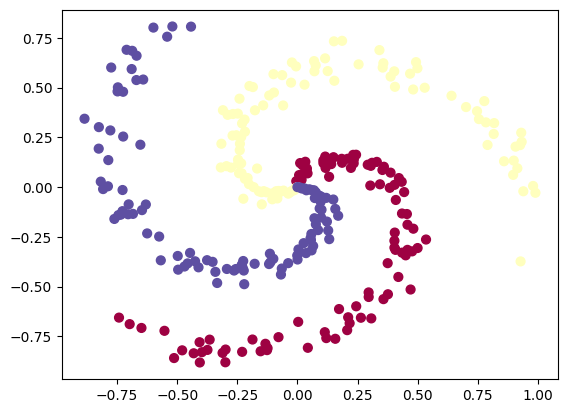

In [137]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [138]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], d